# Implementing a Transformer for language translation

Credits: The transformer-building procedure shown here generally follows the excellent TensorFlow worklfow shown in: https://www.tensorflow.org/text/tutorials/transformer.

I programmed this particular model to show how the algorithm gradually learns and "understands" the languages in real time during training. 

I also made it possible to configure the transformer with differing amounts of encoder and decoder layers, making it a more flexible configuration. 

# Loading main libraries

In [ ]:
!pip install tensorflow_datasets
!pip install -U tensorflow-text

In [2]:
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow as tf

# Loading and manipulating the data

In [3]:
data, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteYUNB4G/ted_hrlr_translate-train.tfrecord


  0%|          | 0/51785 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteYUNB4G/ted_hrlr_translate-validation.tfrecord


  0%|          | 0/1193 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteYUNB4G/ted_hrlr_translate-test.tfrecord


  0%|          | 0/1803 [00:00<?, ? examples/s]

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


## Separate data into training, testing, and validation datasets

In [4]:
train_data = data['train']
test_data = data['test']
validation_data = data['validation']

## learning about the data

In [5]:
print("The traning, validation, and testing splits are:")
metadata.splits

The traning, validation, and testing splits are:


{'test': <tfds.core.SplitInfo num_examples=1803>,
 'train': <tfds.core.SplitInfo num_examples=51785>,
 'validation': <tfds.core.SplitInfo num_examples=1193>}

In [6]:
print("the labeled keys are:")
metadata.supervised_keys

the labeled keys are:


('pt', 'en')

In [7]:
num_of_examples = 5

for port, eng in train_data.batch(num_of_examples).take(1).as_numpy_iterator():
    
    print("Portuguse examples:")
    for p in port:
        print(p.decode("utf-8"))
        
    print("")

    print("English examples:")
    for e in eng:
        print(e.decode("utf-8"))

Portuguse examples:
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .
e esta rebeldia consciente é a razão pela qual eu , como agnóstica , posso ainda ter fé .
`` `` '' podem usar tudo sobre a mesa no meu corpo . ''

English examples:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .
and this conscious defiance is why i , as an agnostic , can still have faith .
you can use everything on the table on me .


# Tokenizing words for Embedding 

Here we use a pre-trained model which we download from a google API. This has been trained for english to portuguese translation. These tokens will then be used for embedding when used as inputs in an embedding layer. 

The cool thing about this particular tokenizer is that it is a sub-word tokenizer, meaning that it not only learns the words themselved, but part of the words as well. This way it can interpolate and find meaning in new words that it might have not seen before.

For example: for the word human, we generate {h, hu, hum, huma, human, ##u, ##um, ##uma, ##uman, ##m, ##ma, ##man, #a, ##an, ##n}.

Tokenizers are built based on a particular vocabulary set, so they need to be trained on your vocabulary before using. 

Note that, in this case, embedding will not be a representation of similarity between words, just a vectorization of said words and sub words. The similarity embedding is actually the output of the encoder.

In [8]:
#downloading model
embed_name = "ted_hrlr_translate_pt_en_converter"
tf.keras.utils.get_file(
    embed_name+".zip",
    "https://storage.googleapis.com/download.tensorflow.org/models/"+embed_name+".zip",
    cache_dir='.', cache_subdir='', extract=True
)

196608/184801 [===============================] - 0s 0us/step


'./ted_hrlr_translate_pt_en_converter.zip'

In [9]:
#load tokenizer model
tokenizer = tf.saved_model.load(embed_name)

In [10]:
#testing tokenizing english words
#Each word token maps to a word-embedding vector in the full embedding matrix.
print("Example text: \n", eng)
en_tokens = tokenizer.en.tokenize(eng)
print("")
print("Example tokens: \n", en_tokens)
en_retoken = tokenizer.en.lookup(en_tokens)
print("")
print("Example un-tokenized text: \n",en_retoken)

Example text: 
 [b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .'
 b'but what if it were active ?' b"but they did n't test for curiosity ."
 b'and this conscious defiance is why i , as an agnostic , can still have faith .'
 b'you can use everything on the table on me .']

Example tokens: 
 <tf.RaggedTensor [[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3], [2, 87, 90, 107, 76, 129, 1852, 30, 3], [2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3], [2, 72, 81, 2508, 2159, 3072, 1282, 80, 192, 45, 13, 100, 111, 6040, 3176, 3186, 13, 94, 235, 89, 1938, 15, 3], [2, 79, 94, 212, 299, 92, 71, 1356, 92, 114, 15, 3]]>

Example un-tokenized text: 
 <tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability', b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage', b'of', b'print', b',', b'which', b'is',

# Creating a Positional Encoder

We now complement the encoder with a measure of position for each word in the sentence. This is done with a sinosoidal function, where words with similar values are close together. This will help us with the self-attention steps. Note that this does not take any data as input; every position in a sentence up to "n" words long is encoded into a vector that is "d" dimensions in size. Therefore, each word in a given sentence/input will have a different position which is described by a different d-sized vector. The result of the following is a n by d tensor.

## Defining Functions

In [11]:
def angle_arguments(position, index, embedding_dimension):
  angle_argument = position / np.power(10000,index/embedding_dimension)
  return angle_argument

def pos_encoding(max_positions, embedding_dimension):
  #creating a max_position by embedding_dimension matrix
  angles = angle_arguments(
                          np.arange(max_positions)[:,np.newaxis], #creating a max_positions by 1 matrix 
                          np.arange(embedding_dimension)[np.newaxis,:], #creating a 1 by emedding_dimension matrix 
                          embedding_dimension
                          )
  
  #appling sine to even indices
  angles[:,0::2] = np.sin(angles[:,0::2])

  #applying cosine to uneven indices
  angles[:,1::2] = np.cos(angles[:,1::2])

  #returning a 3-D matrix of 1 by max_position by embedding_dimension
  return tf.cast(angles[np.newaxis, ...], dtype=tf.float32)


## Performing encoding and checking

The shape of the positional encoding is:  (1, 2048, 512)


Text(0, 0.5, 'Embedding Dimension')

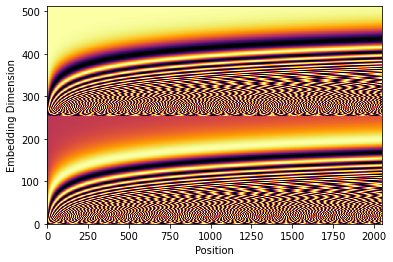

In [12]:
#defining variables
max_position = 2048
embedding_dimension = 512

#performing enconding
positional_encoding = pos_encoding(max_position,embedding_dimension)

#checking shape
print("The shape of the positional encoding is: ", positional_encoding.shape)

#visual check
positional_encoding = tf.reshape(positional_encoding, (max_position, embedding_dimension//2, 2)) #reshaping into a max_position, by embedding/2 by 2
positional_encoding = tf.transpose(positional_encoding, (2, 1, 0)) # transposing to make 2-d vector
positional_encoding = tf.reshape(positional_encoding, (embedding_dimension, max_position)) # reshaping vector
plt.pcolormesh(positional_encoding,cmap="inferno")
plt.xlabel("Position")
plt.ylabel("Embedding Dimension")

# Creating masks for the input

## Create mask to prevent looking into future words

In [13]:
def make_look_ahead_mask(entry_size):
  """
  This will create a diagonal matrix with 0's on the lower half and 1 in the upper half. 
  The code will only use the 0 entries when training the i'th word. 
  We want to use the values with mask =0 and discard values with mask = 1
  """
  base = tf.ones((entry_size,entry_size))
  mask = 1-tf.linalg.band_part(base,-1,0) #the -1, 0 arguments zero-out the lower diagonal
  return mask

make_look_ahead_mask(5)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.]], dtype=float32)>

## create maks to prevent pad tokens from being used

padding is done to make all the sentences the same length by adding zeros. We dont want to procces these zeros. 

In [14]:
def make_padding_mask(entry):
  """
  Returns a 1 where there is padding, i.e where entry = 0
  We want to use the values with mask =0 and discard values with mask = 1
  """
  #getting the mask
  entry = tf.math.equal(entry,0)

  #casting into a tf tensor
  entry = tf.cast(entry, tf.float32)

  #adding extra dimensions for input into attention heads
  #this will have the size: batchSize, 1, 1, sentence_size
  return entry[:,tf.newaxis,tf.newaxis,:]

#test
test = tf.constant([[0, 5 , 5, 5, 5, 0, 0],[0, 0 , 0, 0, 5, 0, 0]])
make_padding_mask(test)


<tf.Tensor: shape=(2, 1, 1, 7), dtype=float32, numpy=
array([[[[1., 0., 0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 1., 0., 1., 1.]]]], dtype=float32)>

# Implementing attention

## Scaled dot product attention

the q = query value is a matrix that indicated which k=key values you want to sample and compare. The k = key values then map the query values to the actual values. Therefore, the scaled weights (the output of the softmax) indicated which values you are comparing and will always add up to one. You will see this in the testing phase.

In [15]:
def dot_product_attention(q, k, v, mask):
  
  #multiply q with k^t
  #this will create a ... by q_length by k_length matrix
  q_k = tf.matmul(q,k,transpose_b=True)

  #scale by the size of the embedding dimension (the last dimension in the keys input
  sqrt_d = tf.math.sqrt(tf.cast(tf.shape(k)[-1],tf.float32))
  q_k_scaled = q_k / sqrt_d

  #adding the mask
  #if mask is = 1 then values will be esentially zeroed-out
  #large negative values in the softmax will essentially by zero. 
  if mask is not None:
    q_k_scaled -= (mask*1e9) 

  #applying the softmax
  #this will keep the ... by q_length by k_length matrix
  weights = tf.nn.softmax(q_k_scaled,axis=-1)

  #multiplying by v
  #create a ... by q_length by v_length matrix
  output  = tf.matmul(weights,v)

  return tf.cast(output,tf.float32), tf.cast(weights,tf.float32)



In [16]:
#testing and getting intuition

def print_attention(q,k,v):
  out, weights = dot_product_attention(q,k,v,None)
  print("The weights are: ")
  print(weights)
  print("the output is:")
  print(out)

np.set_printoptions(suppress=True)


In [17]:
k_test = tf.constant([[10, 0, 0],
                     [0, 10, 0],
                     [0, 0, 10],
                     [0, 0, 10]], dtype=tf.float32)  # (4, 3)

v_test = tf.constant([[1, 0],
                     [10, 0],
                     [100, 5],
                    [1000, 6]], dtype=tf.float32)  # (4, 2)


q_test = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)

#Note that this query maps towards the second key (they are the same)
#therefore the output will pertain to the secod value
print_attention(q_test, k_test, v_test)

The weights are: 
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
the output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


note how the weights =1 because we only select one value. and how the output is the selected value vector (the second one).


In [18]:
k_test = tf.constant([[10, 0, 0],
                     [0, 10, 0],
                     [0, 0, 10],
                     [0, 0, 10]], dtype=tf.float32)  # (4, 3)

v_test = tf.constant([[1, 0],
                     [10, 0],
                     [100, 5],
                    [1000, 6]], dtype=tf.float32)  # (4, 2)


q_test = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)

#Note that this query is similar to both the first and second key 
#therefore the weight will weight the first and second key equaly
# and the output will then be the weighted value of the first and second value
print_attention(q_test, k_test, v_test)

The weights are: 
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
the output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


Note how the sum weights = 1 (due to the softmax), and the outputs are the weighted values of the 1st and second values.

Essetially the "attention" procces uses the query and key vectors to create a weighted vector of certain values.

Note that for self-attention, q,k,v are all the same


## Multiheaded attention

In this section we essentially transform and train the q,k,x values before feeding them into the dot product attention layer. 

In [19]:
class MultiHeadAttention(tf.keras.layers.Layer):

  #note: 
        #batch_size = # of sentences/samples in each batch
        #sample_length = #numbef of words in a sentence
        #num heads = number of self-attention heads
        #depth =  number of embedding dimensions handled by each head

  #initializing the object
  def __init__(self, embedding_dimension, number_of_heads):
    #inheriting the same init as the base class (tf.keras.layers.Layer)
    super().__init__()
    self.num_heads = number_of_heads
    self.embed_dim = embedding_dimension

    #calculating how many units each linear layer should have
    self.depth = self.embed_dim // self.num_heads 

    #checking that we can separate the number of dimenisons into the number of heads
    #if not stop building the layer
  
    assert self.embed_dim % self.num_heads ==0

    #create linear layers with the number of dimensions (these will be split later)
    #creating the q layer
    self.q_layer = tf.keras.layers.Dense(embedding_dimension)

    #creating the k layer
    self.k_layer = tf.keras.layers.Dense(embedding_dimension)

    #creating the v layer
    self.v_layer = tf.keras.layers.Dense(embedding_dimension)

    #creating the output layer (after attention is calculated)
    self.output_layer = tf.keras.layers.Dense(embedding_dimension)


  def separating_heads(self, layer, batch_size):
    #input layer has size of sequence_length by embedding dimension
    #we will create layers that have size: depth by sequence_length

    #reshaping the layer
    #-1 implies the length of the dimension is infered by the program
    layer = tf.reshape(layer,(batch_size,-1, self.num_heads, self.depth)) 

    #transposing the layer to get (batch_size, num_heads, sequence_length, depth)
    layer = tf.transpose(layer,perm=[0, 2, 1, 3])

    return layer

  def call(self, q, k, v, mask):
    #obtaining the batch size. This will be the number of sentences in the query vector
    batch_size = tf.shape(q)[0] 

    #passing q, v, and k into their respective layers and getting the output
    #size  = sequence_length (q_size) by embedding_dimension
    q = self.q_layer(q) 
    k = self.k_layer(k) 
    v = self.v_layer(v) 

    #splitting the output layers
    #size = (size_batche, num_heads, sequence_length, depth)
    q_out = self.separating_heads(q,batch_size)
    k_out = self.separating_heads(k,batch_size)
    v_out = self.separating_heads(v,batch_size)

    #passing the output of the linearized q,k,v vectors into the dot product attention
    #output shape = (batch_size, num_heads, sequence_length, depth)
    #weight shape = (batch_size, num_heads, sequence_length, length_k)
    attention_output, attention_weights = dot_product_attention(q=q_out,k=k_out,v=v_out,mask=mask)

    #combining the previous outputs to fit into the output layer (un-doing the separating_heads opperation)
    attention_output = tf.transpose(attention_output, perm=[0, 2, 1, 3])
    attention_output = tf.reshape(attention_output,(batch_size,-1,self.embed_dim))

    #the result is a tensor with the size: batch_size , sequence_length, embedding_dimension)

    #passing through the output layer
    out = self.output_layer(attention_output)

    return out, attention_weights



## Testing full self-attention

In [20]:
#initializing attention head
num_heads = 4
test_attention = MultiHeadAttention(embedding_dimension,num_heads)

#initializing input of size: batch_size, sequence_length, embedding_dimension
batch_size = 1
test_q_size = 60 #length of sequence (how long is a sentence)
test_input = tf.random.uniform((batch_size,test_q_size,embedding_dimension)) #Outputs random values from a uniform distribution.

#running attention
#Note that for self-attention, q,k,v are all the same
test_output, test_weights = test_attention(test_input,test_input,test_input,None)

#looking at sizes
print("Shape of the output:", test_output.shape)
print("Shape of the weights:", test_weights.shape)


Shape of the output: (1, 60, 512)
Shape of the weights: (1, 4, 60, 60)


# Last component of encoder: the standard feed-forward network

In [21]:
def feed_forward_nn(embedding_dimension,hidden_units):
  #note that we want hidden_units = length_of_positional encoder for a 1-to-1
  #ratio, but it could be anything
  #here we create a NN object, but no data is passed through yet
  
  ffnn = tf.keras.Sequential([
              #input size: batch_size by sample_legth, by embed_dimension
              #output size = batch_size by sample_length by hidden units. 
              tf.keras.layers.Dense(hidden_units,activation="relu"),

              #output size = batch_size,num_samples, embedding dimension. 
              tf.keras.layers.Dense(embedding_dimension)
  ])

  return ffnn


#Putting things together into a single Encoder layer

In [22]:
class encoder_layer(tf.keras.layers.Layer):
  def __init__(self, embed_dim, num_heads, hidden_units_ffnn, dropout_rate = 0.1):
    super().__init__()

    #initializing the layer objects
    self.MHA_layer = MultiHeadAttention(embed_dim,num_heads)
    self.MHA_dropout = tf.keras.layers.Dropout(dropout_rate)
    self.MHA_norm_layer = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.ffnn_layer = feed_forward_nn(embed_dim, hidden_units_ffnn)
    self.ffnn_dropout = tf.keras.layers.Dropout(dropout_rate)
    self.ffnn_norm_layer = tf.keras.layers.LayerNormalization(epsilon=1e-6)

  def call (self,data,mask,is_training):

    #running Multihead attention
    att_output, MHA_weights = self.MHA_layer(q=data,k=data,v=data,mask=mask)
    drop_output = self.MHA_dropout(att_output, training=is_training)
    #re-adding original data back before normalization
    norm_output = self.MHA_norm_layer(drop_output+data)

    #running feed-forward neural network
    ffnn_output = self.ffnn_layer(norm_output)
    ffnn_drop_output = self.ffnn_dropout(ffnn_output, training=is_training)
    final_output = self.ffnn_norm_layer(ffnn_drop_output + norm_output)

    return final_output


In [23]:
#testing

#initializing
enconder_test = encoder_layer(512,8,2048)

#creating data: batch_size, sequence_length, embed_dimension
data_encoder_test = tf.random.uniform((54,204,512))

#running
enconder_out_test = enconder_test(data_encoder_test,None,False)

print("encoder input shape: ",data_encoder_test.shape)
print("encoder output shape: ",enconder_out_test.shape)

encoder input shape:  (54, 204, 512)
encoder output shape:  (54, 204, 512)


# Putting things together into a single Decoder layer

In [24]:
class decoder_layer(tf.keras.layers.Layer):
  def __init__(self, embed_dim, num_heads, hidden_units_ffnn, dropout_rate = 0.1):
    super().__init__()

    #initializing the layer objects
    self.MHA_layer_1 = MultiHeadAttention(embed_dim,num_heads)
    self.MHA_dropout_1 = tf.keras.layers.Dropout(dropout_rate)
    self.MHA_norm_layer_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.MHA_layer_2 = MultiHeadAttention(embed_dim,num_heads)
    self.MHA_dropout_2 = tf.keras.layers.Dropout(dropout_rate)
    self.MHA_norm_layer_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.ffnn_layer = feed_forward_nn(embed_dim, hidden_units_ffnn)
    self.ffnn_dropout = tf.keras.layers.Dropout(dropout_rate)
    self.ffnn_norm_layer = tf.keras.layers.LayerNormalization(epsilon=1e-6)

  def call(self,data,encoder_output,padding_mask,lookahead_mask,is_training):
    #running 1st multihead attention
    att_output_1, MHA_weights_1 = self.MHA_layer_1(
        q=data,k=data,v=data,mask=lookahead_mask)
    drop_output_1 = self.MHA_dropout_1(att_output_1, training=is_training)
    #re-adding original data back before normalization
    norm_output_1 = self.MHA_norm_layer_1(drop_output_1+data)

    #running 2nd multihead attention
    #note that now q = last output, and v, k = encoder_output
    att_output_2, MHA_weights_2 = self.MHA_layer_2(
        q=norm_output_1,k=encoder_output,v=encoder_output,mask=padding_mask)
    drop_output_2 = self.MHA_dropout_2(att_output_2, training=is_training)
    #re-adding original data back before normalization
    norm_output_2 = self.MHA_norm_layer_2(drop_output_2+norm_output_1)

    #running feed-forward neural network
    ffnn_output = self.ffnn_layer(norm_output_2)
    ffnn_drop_output = self.ffnn_dropout(ffnn_output, training=is_training)
    final_output = self.ffnn_norm_layer(ffnn_drop_output+norm_output_2)

    return final_output, MHA_weights_1, MHA_weights_2

In [25]:
#testing

#defining data (note batch size and embed_dim must be the same as for the encoder)
decoder_data_test = tf.random.uniform((54,45,512))

#initalizing decoder
decoder_test = decoder_layer(512,4,2048,0.1)

#running decoder
output_decoder_test, w, w2 = decoder_test(decoder_data_test,enconder_out_test,None,None,False)

print("decoder input shape: ",decoder_data_test.shape)
print("decoder output shape: ",output_decoder_test.shape)

decoder input shape:  (54, 45, 512)
decoder output shape:  (54, 45, 512)


# Creating a full **Encoder** (embedding + positional encoding + encoder layers)

In [26]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, embedding_dimension, max_position_encoding,
               input_vocabulary_size,MHA_num_heads,number_of_encoder_layers,
               num_ffnn_hidden_layers,dropout_rate=0.1,):
    super().__init__()

    #initializing parameters
    self.embed_dim = embedding_dimension
    self.num_of_layers = number_of_encoder_layers

    #initializing word embedding layer
    self.embedding = tf.keras.layers.Embedding(input_vocabulary_size,
                                               embedding_dimension)

    #creating positional encodings (no data needed for this)
    self.pos_encode = pos_encoding(max_position_encoding,embedding_dimension)

    #creating list containing N embedding layers
    self.encoder_layers = [encoder_layer(embedding_dimension,MHA_num_heads,
                          num_ffnn_hidden_layers,dropout_rate)
                          for i in range(number_of_encoder_layers)]

    #creating dropout layer
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call (self,input_data,is_training,mask):

    #calculating the length of the sentence/sequence (size of second column)
    length = tf.shape(input_data)[1]

    #embedding data
    embed_data = self.embedding(input_data)
    #scaling the data by the sqrt of the embedding dimension
    embed_data *= tf.math.sqrt(tf.cast(self.embed_dim,tf.float32))

    #adding the positional encoding which has size (batch_size ,position, embed_dim)
    #Here we are only adding the positional encoder up to the number of words 
    #in the sequence
    embed_data += self.pos_encode[:,:length,:]

    #adding a dropout layer at the start of the encoder (this is optional)
    out = self.dropout(embed_data,training=is_training)

    #passing data through the N encoding layers
    for i in range(self.num_of_layers):
      out= self.encoder_layers[i](out,mask,is_training)

    return out

In [27]:
#Testing encoder

#initializing encoder
test_Encoder = Encoder(512,10000,8500,8,2,20148)

#initializing data (just a number samples by num of tokenized words matrix)
test_Encoder_input = tf.random.uniform((55,87),dtype=tf.int64,minval=0, maxval=500)

#running encoder
test_E_output = test_Encoder(test_Encoder_input,False,None)

print("Encoder input shape: ",test_Encoder_input.shape)
print("Encoder output shape: ",test_E_output.shape)


Encoder input shape:  (55, 87)
Encoder output shape:  (55, 87, 512)


# Creating a full **Decoder** (embedding + positional encoding + decoder layers)

In [28]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, embedding_dimension, max_position_encoding,
               target_vocabulary_size,MHA_num_heads,number_of_decoder_layers,
               num_ffnn_hidden_layers,dropout_rate=0.1,):
    super().__init__()

    #initializing parameters
    self.embed_dim = embedding_dimension

    #initializing word embedding layer
    self.embedding = tf.keras.layers.Embedding(target_vocabulary_size,
                                               embedding_dimension)

    #creating positional encodings (no data needed for this)
    self.pos_encode = pos_encoding(max_position_encoding,embedding_dimension)

    #creating list containing N embedding layers
    self.decoder_layers = [decoder_layer(embedding_dimension,MHA_num_heads,
                          num_ffnn_hidden_layers,dropout_rate)
                          for i in range(number_of_decoder_layers)]

    #creating dropout layer
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self,input_data, encoder_data,padding_mask,lookahead_mask,is_training):

    #calculating the length of the sentence/sequence (size of second column)
    length = tf.shape(input_data)[1]
    weights = {}

    #embedding data
    embed_data = self.embedding(input_data)
    #scaling the data by the sqrt of the embedding dimension
    embed_data *= tf.math.sqrt(tf.cast(self.embed_dim,tf.float32))

    #adding the positional encoding which has size (batch_size ,position, embed_dim)
    #Here we are only adding the positional encoder up to the number of words 
    #in the sequence
    embed_data += self.pos_encode[:,:length,:]

    #adding a dropout layer at the start of the encoder (this is optional)
    out = self.dropout(embed_data,training=is_training)

    #passing data through the N decoding layers
    i=0
    for layer in self.decoder_layers:
      padding_mask,lookahead_mask,is_training
      out, w1, w2 = layer(out,encoder_data,padding_mask,
                  lookahead_mask,is_training)
      
      weights["decoder_layer_"+str(i+1)+"block_1_weights"] = w1
      weights["decoder_layer_"+str(i+1)+"block_2_weights"] = w2
     
      i+=1

    return out, weights

In [29]:
#Testing decoder

#initializing encoder
test_Decoder = Decoder(512,10000,8500,8,2,20148)

#initializing data (just a number samples by num of tokenized words matrix)
#batch size has to be the same as encoder input
test_Decoder_input = tf.random.uniform((55,45),dtype=tf.int64,minval=0, maxval=500)

#running encoder
test_D_output, test_D_weights = test_Decoder(test_Decoder_input,test_Encoder_input,None,None,False)

print("Decoder input shape: ",test_Decoder_input.shape)
print("Decoder output shape: ",test_D_output.shape)

Decoder input shape:  (55, 45)
Decoder output shape:  (55, 45, 512)


# Finally! Creating the **Transformer**

In [30]:
class Transformer(tf.keras.Model):
  def __init__(self, embedding_dimension, max_position_encoding_input,
              max_position_encoding_target, input_vocabulary_size,
              target_vocabulary_size, MHA_num_heads, number_of_encoder_layers,
              number_of_decoder_layers, num_ffnn_hidden_layers,dropout_rate=0.1
              ):
    super().__init__()

    #creating the encoder
    self.Encoder = Encoder(embedding_dimension, max_position_encoding_input,
                           input_vocabulary_size,MHA_num_heads,
                           number_of_encoder_layers,num_ffnn_hidden_layers)
    
    #creating decoder layer
    self.Decoder = Decoder(embedding_dimension,max_position_encoding_target,
                           target_vocabulary_size,MHA_num_heads,
                           number_of_decoder_layers,num_ffnn_hidden_layers)
    
    #creating final layer
    self.final = tf.keras.layers.Dense(target_vocabulary_size)

  def createMasks(self,input_val,target_val):

    #creating mask for encoder (this is a padding mask)
    encoder_pad_mask = make_padding_mask(input_val)

    #creating masks for 1st decoder block (both padding and lookahead mask)
    decoder_pad_mask_1=make_padding_mask(target_val)
    decoder_la_mask_1=make_look_ahead_mask(tf.shape(target_val)[1]) #val_length
    #combining both decoder masks for lookahead mask 
    #(we dont want to account for padding values here either)
    decoder_la_mask_1=tf.maximum(decoder_pad_mask_1, decoder_la_mask_1)

    #creating masks for 2nd decoder block
    decoder_pad_mask_2 = make_padding_mask(input_val)

    return encoder_pad_mask, decoder_la_mask_1, decoder_pad_mask_2

  def call(self, all_inputs, is_training):
    
    #remember inputs are in the form of a 2-part tuple/list (english first
    # then portuguse)
    inputs, targets = all_inputs

    #getting the masks
    enc_pad_mask, dec_la_mask, dec_pad_mask = self.createMasks(inputs,targets)

    #running the encoder
    enc_out = self.Encoder(inputs, is_training, enc_pad_mask)

    #running the decoder
    dec_out, weights = self.Decoder(targets, enc_out,dec_pad_mask,
                           dec_la_mask, is_training)
    
    #running through last layer
    #shape: # (batch_size, target_sencence_len, target_vocab_size)
    last_output = self.final(dec_out)

    return last_output, weights

In [31]:
#Testing Transformer

#initializing transformer
test_T = Transformer(512,10000,6000,8500,8000,8,2,2,2048)

#initializing data (just a number samples by num of tokenized words matrix)
#batch size has to be the same as encoder input
test_T_input = tf.random.uniform((55,45),dtype=tf.int64,minval=0, maxval=500)
test_T_target = tf.random.uniform((55,47),dtype=tf.int64,minval=0, maxval=500)

#running Transformer
test_T_output, test_T_weights = test_T([test_T_input,test_T_target],False)

#output shape should be # (batch_size, tar_seq_len, target_vocab_size)
print("Transformer input shape: ",test_T_input.shape)
print("Transformer output shape: ",test_T_output.shape)

Transformer input shape:  (55, 45)
Transformer output shape:  (55, 47, 8000)


# Defining Training Procedures

## Defining a Loss Function

We will be using a cross-entropy loss function (negative log-likelyhood). Also, remember that we dont want to calculate a loss function on the padding sentence values. 

In [32]:
#initailizing loss function oject
#we will be inputing the logits instead of the outputs of a softmax function
cross_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction="none")

def loss_fn(labels,predictions):
  #creating a mask for padding labels
  #(first returning 1's where there are zeros, then inverting)
  #note that summing over pad_mask gives total number of classifiable samples
  pad_mask = tf.math.logical_not(tf.math.equal(labels,0))

  #calculating loss
  calc_loss = cross_loss(labels,predictions)

  #applying mask to loss
  pad_mask = tf.cast(pad_mask,dtype=calc_loss.dtype)
  calc_loss = calc_loss*pad_mask #multipyling padding losses by zero

  #calculating total loss
  calc_loss = tf.reduce_sum(calc_loss)/tf.reduce_sum(pad_mask)

  return calc_loss

def calc_accuracy(labels, predictions):

  #checking if the predictid value equals the label
  #here we check if the word with the max output probabilty matches the label
  equal = tf.equal(labels,tf.argmax(predictions,axis=2))

  #creating a mask for padding labels
  #(first returning 1's where there are zeros, then inverting)
  #note that summing over pad_mask gives total number of classifiable samples
  pad_mask = tf.math.logical_not(tf.math.equal(labels,0))

  #applying the mask using AND function (only equals 1 if both equal 1)
  equal = tf.math.logical_and(pad_mask,equal)

  #casting into appropriate types
  equal = tf.cast(equal,tf.float32)
  pad_mask = tf.cast(pad_mask,tf.float32)

  #calculating accuracy
  acc = tf.reduce_sum(equal)/tf.reduce_sum(pad_mask)

  return acc

## Defining an optimal learning rate

Here we follow the formula specified in "Attention is all you Need" (i.e. the landmark transformer paper which we are using here). The following class "modulates how the learning rate of your optimizer changes over time."



In [33]:
class learning_rate_optimizer(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, embedding_dimension, warm_up_steps=4000):
    super().__init__()

    self.emb_dim = embedding_dimension
    self.w_s = warm_up_steps

  def __call__(self,current_step):
    #calculating arguments in minimun function
    min1 = tf.math.rsqrt(current_step)
    min2 = current_step * (self.w_s ** -1.5)

    #calculating result of min function
    min = tf.math.minimum(min1,min2)

    #calculating sqrt of the embeding dimension
    d_rsqrt =  tf.math.rsqrt(tf.cast(self.emb_dim,tf.float32))

    #calculating rate
    rate = d_rsqrt*min

    return rate


In [34]:
#Testing learning rate

#initializing rate optimizer
#rate_test = learning_rate_optimizer(100)

#plotting learning rate vs time step
#plt.plot(rate_test(tf.range(50000, dtype=tf.float32)))
#plt.ylabel("Rate")
#plt.xlabel("Current Step")

# Training 

## Creating Suitable Input Data

In [35]:
# creating function to tokenize the text

def tokenize_text(port_data, eng_data):
  eng_data = tokenizer.en.tokenize(eng_data).to_tensor() #we cast into a sparse tensor 
  port_data = tokenizer.pt.tokenize(port_data).to_tensor() #we cast into a sparse tensor

  return port_data, eng_data

In [36]:
#making batches
def make_batches(Data,buffer_size,batch_size):
  return (
      Data
      .cache()
      .shuffle(buffer_size)
      .batch(batch_size)
      .map(tokenize_text, num_parallel_calls=tf.data.AUTOTUNE)
      .prefetch(tf.data.AUTOTUNE))
  
#final data
train_batches = make_batches(train_data,20000,64)
test_batches = make_batches(test_data,20000,64)
val_batches = make_batches(validation_data,20000,64) 

## Initalizing the Transformer and Training Procedures

In [37]:
#defining model hyperparameters
embed_dim = 128
max_positional_input = 1000
max_positional_target = 1000
input_vocab_size = 8000# tokenizer.pt.get_vocab_size().numpy() #translate eng  to port
target_vocab_size = 8500 # tokenizer.en.get_vocab_size().numpy()
num_MHA_heads = 8
num_E_layers = 4
num_D_layers = 4
ffnn_layers = 512
dropout_rate = 0.1

#defining Transformer
transformer = Transformer(embed_dim,max_positional_input,max_positional_target,
                          input_vocab_size,target_vocab_size,num_MHA_heads,
                          num_E_layers,num_D_layers,ffnn_layers,dropout_rate)

#defining learning rate optimizer
learn_rate = learning_rate_optimizer(embed_dim)

#defining Neural Network optimizer 
optimizer = tf.keras.optimizers.Adam(learn_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

#initailzing training loss objects (will calculate mean of loss after e/ epoch)
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc =  tf.keras.metrics.Mean(name='train_acc')


## Defining function to print inputs, predictions,and labels

In [38]:
#defining evaluating function
def eval_function(input_sentence,predicted_sentence,real_translation):

  #Getting Input sentence
  detokenized_input = tokenizer.en.detokenize(input_sentence)[0]
  print("Input Sentence: \n" + detokenized_input.numpy().decode('utf-8') + "\n")

  #Getting Prediction Sentence
  prediction = predicted_sentence[:, :30, :] 
  prediction_tokens = tf.argmax(prediction,axis=-1)
  detokenized_pred = tokenizer.pt.detokenize(prediction_tokens)[0]
  print("Predicted Sentence: \n" + detokenized_pred.numpy().decode('utf-8') + "\n")

  #Getting Target Sentence
  detokenized_real = tokenizer.pt.detokenize(real_translation)[0]
  print("Real Translation: \n" + detokenized_real.numpy().decode('utf-8') + "\n")



## Checkpoint training 

Here we will efine a checkpoint routine in case training stops or we want to continue training later. 

In [39]:
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)

# defining directory to store checkpoints
path = "/content/gdrive/MyDrive/ColabNotebooks/"

#check point will save the states of the transformer and optimizer
check_pt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

#defining checkpoint manager
check_pt_manager = tf.train.CheckpointManager(check_pt,path,5)

Mounted at /content/gdrive/


## Single step training

In [40]:
# defining how training happens in a single step (i.e. training gradient decent)

#defining the size of the inputs in the training step
train_step_sig = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64)
]

#this function is defined through @tf to signal in order to compile the 
#subfunctions within it into the tensorflow code. This way it does not need to
# be recompiled in each iteration. In other words, it makes it a part of the 
#tensorflow graph
@tf.function(input_signature=train_step_sig)
def training_step(input,target):
  
  #shifting the target input and target labels 
  #(the transformer needs to predict the nth word in the target label
  #by only recieving the n-1 words before it. )
  #note we are making them the same size
  target_input = target[:,:-1]
  target_label = target[:,1:]

  #Training the model
  #the WITH and AS syntax allows the code to run cleanly
  with tf.GradientTape() as tape:
    
    #getting predictions from transformer
    prediction, weights = transformer([input,target_input],is_training=True)

    #calculating losses
    loss = loss_fn(target_label,prediction)

  #calculating gradients w.r.t. the trainable variables
  grad = tape.gradient(loss,transformer.trainable_variables)

  #applying the gradients to the trainable variables
  #note that "zip" groups together the nth values of each input
  optimizer.apply_gradients(zip(grad, transformer.trainable_variables))

  #calculating the mean loss and accuracy
  train_loss(loss)
  train_acc(calc_accuracy(target_label,prediction))

  return prediction


## Epoch Training

In [41]:
#defining training epochs (number of times the complete data set is passed)
EPOCHS = 20

#restore latest checkpoint
if check_pt_manager.latest_checkpoint:
  check_pt.restore(check_pt_manager.latest_checkpoint)

#defining how we train for each epoch
for epoch in range(EPOCHS):

  #defining start time
  start_time = time.time()

  #reset epoch-mean losses
  train_loss.reset_states()
  train_acc.reset_states()

  #using the data from the train_batches defined above
  for (batch,(target,input)) in enumerate(train_batches):
    
    #running gradient decent
    prediction = training_step(input,target)

    #print intermediate results every n batches
    if batch % 800 == 0:
      print("-----------------------------------------------------------")
      print(f"Epoch: {epoch +1}, Batch: {batch}, Loss: {train_loss.result():.4f}, Accuracy: {train_acc.result():.4f} \n")

      #looking at outputs
      eval_function(input,prediction,target)
      
      #save checkpoint
      check_pt_save = check_pt_manager.save()

  #print results of training
  print("-----------------------------------------------------------")
  check_pt_save = check_pt_manager.save()
  print(f"Saving training for Epoch{epoch+1}")

  #print final result
  print(f"Epoch: {epoch +1}, Batch: {batch}, Loss: {train_loss.result():.4f}, Accuracy: {train_acc.result():.4f}")

  #printing time
  print(f'Time spent in last epoch: {time.time() - start_time:.2f} secs\n')
  print("-----------------------------------------------------------")
 
  #Note: stop at around accuracy: 0.68 (inclemental gains)

-----------------------------------------------------------
Epoch: 1, Batch: 0, Loss: 9.0935, Accuracy: 0.0000 

Input Sentence: 
suddenly , i had an episode of catastrophic bleeding .

Predicted Sentence: 
desafio desafio fechado desafio desafio desafio desafio desafio nariz desafio facamos desafio avaliar desafio facamos desafio desafio facamos desafio desafio desafio necessidades facamos desafio desafio desafio desafio [UNK] desafio facamos

Real Translation: 
de repente , tive um episodio de hemorragia catastrofica .

-----------------------------------------------------------
Epoch: 1, Batch: 800, Loss: 6.9945, Accuracy: 0.1009 

Input Sentence: 
so yes , i think it ' s a good idea for a company to use this certificate to make sure to make fact - based decisions in the future .

Predicted Sentence: 
e , e que a que minha que , que minha , , que , que , a , , a que , e , , que , .

Real Translation: 
portanto , acho que e uma boa ideia para uma empresa usar este certificado para ga

# Using the Trained Model

Note that during training we trained the model to predict the whole resulting sequence based on an input. This was done to make training more efficient (avoiding having to re-enter the latest predicted word back into the input sentence and so on). However, during inference/translation we only care about the next word in the sequence. 

**During training:**

encoder input = portuguese sentence

decoder input = english sentence

output = whole english sentence

labels = english sentence

**During inference:**

encoder input = portugues sentence

decoder input = first n words in the sequence (starting from eng. start token)

output = whole english sentence (we only care about n+1 word, which we then re-enter into the decoder for the next word prediciton).

## Creating a Translator

In [42]:
class Translator (tf.Module):
  def __init__(self,tokenizer,transformer):
    
    #initalizing class models
    #we input the trained tokenizer and the trained transformer instance
    self.tokenizer = tokenizer
    self.transformer = transformer

  def __call__(self,input_sentence,max_sentence_length=30):
    #input sentence (portuguese)
    #check if sentence is a TF tensor
    assert isinstance(input_sentence,tf.Tensor)

    #making the sentence into a tensor if its just 1 dimensional
    if len(input_sentence.shape) == 0:
      input_sentence = input_sentence[tf.newaxis]

    #tokenizing the input sentence
    encoder_input = self.tokenizer.en.tokenize(input_sentence).to_tensor()

    #obtaining the start tokens for the decoder input
    empty_sentence = [""]
    start_and_end_tokens = self.tokenizer.pt.tokenize(empty_sentence)[0]
    start_token = start_and_end_tokens[0][tf.newaxis]
    end_token = start_and_end_tokens[1][tf.newaxis]
    
    #initalizing an transformer output array. This is going to be used to 
    #show the results, but also to feed back into the decoder until 
    #the end_token is produced.
    output_list = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    
    #inputing the start_token into the output array in location zero
    output_list = output_list.write(0,start_token)

    #starting the loop of calling the transformer and filling out the output
    for i in tf.range(max_sentence_length):

      #changing the output list into a readable format
      decoder_input = tf.transpose(output_list.stack())

      #geting the n+1 predictions
      prediction, trash = self.transformer([encoder_input,decoder_input],
                                             is_training=False)

      #getting the output probabilites predicting the last sentence
      prediction = prediction[:, -1:, :]  # (batch_size, 1, vocab_size)

      #getting the last token
      prediction_token = tf.argmax(prediction,axis=-1)

      #adding to the output array
      output_list = output_list.write(i+1,prediction_token[0])

      #stop if predicted token is the end_token
      if prediction_token == end_token:
        break

    #casting output into readoble frorm
    output = tf.transpose(output_list.stack())

    #detokenizing into a sentence
    detokenized_text = self.tokenizer.pt.detokenize(output)[0]

    #detokenizing into tokens
    detokenized_tokens = self.tokenizer.pt.lookup(output)[0]

    #getting the weights of the last prediction 
    trash_2, weights = self.transformer([encoder_input,output[:,:-1]],
                                        is_training=False)

    return detokenized_text, detokenized_tokens, weights


## Running/Testing the Translator

In [43]:
#restoring latest checkpoint if neccesary

#latest = tf.train.latest_checkpoint(path)
#check_pt.restore(latest)

In [44]:
#creating the instance with trained tokenizer and transformer models
translator=Translator(tokenizer,transformer)

#defining attention plotting function
def plot_attention(input_sentence,output_tokens,att_weights):

  #trasforming input sentence to tokens
  input_tokens = tf.convert_to_tensor([input_sentence])
  input_tokens = tokenizer.en.tokenize(input_tokens).to_tensor()
  input_tokens = tokenizer.en.lookup(input_tokens)[0]
  
  #removing the first token (we gave this to the model)
  output_tokens = output_tokens [1:]

  #getting the attention weights of all heads of the 2nd block
  # of the last decoder (4th layer)
  attention_heads = tf.squeeze(att_weights['decoder_layer_4block_2_weights'], 0)
  
  weights = attention_heads[0]

  print("The attention plot for the 1st head of the last decoder attention block is:")

  #making plot
  plot = plt.gca()
  plot.matshow(weights)
  plot.set_xticks(range(len(input_tokens)))
  plot.set_yticks(range(len(output_tokens)))
  
  labels_x = [label.decode('utf-8') for label in input_tokens.numpy()]
  plot.set_xticklabels(labels_x, rotation=90)

  labels_y = [label.decode('utf-8') for label in output_tokens.numpy()]
  plot.set_yticklabels(labels_y)

#defining evaluating function
def eval_plotting_function(input_sentence,predicted_sentence,output_tokens, att_weights, real_translation):
  print("Input Sentence: \n" + input_sentence +"\n" )
  print("Predicted Sentence: \n" + predicted_sentence.numpy().decode("utf-8")+"\n")
  print("Real Translation: \n" + real_translation+"\n")

  #pritting attention plots
  plot_attention(input_sentence,output_tokens,att_weights)




Input Sentence: 
The cat fell from the tree.

Predicted Sentence: 
o gato caiu da arvore .

Real Translation: 
o gato caiu da árvore

The attention plot for the 1st head of the last decoder attention block is:


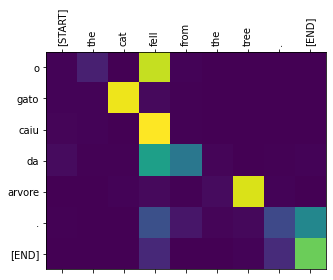

In [46]:
#test sentence 1:
input_sentence = "The cat fell from the tree."
real_translation = "o gato caiu da árvore"

#getting predicting
prediction, tokens, weights = translator(tf.constant(input_sentence))

eval_plotting_function(input_sentence,prediction,tokens,weights,real_translation)

Input Sentence: 
I love to code transformers.

Predicted Sentence: 
adoro transformar os codigos .

Real Translation: 
adoro programar os transformers.

The attention plot for the 1st head of the last decoder attention block is:


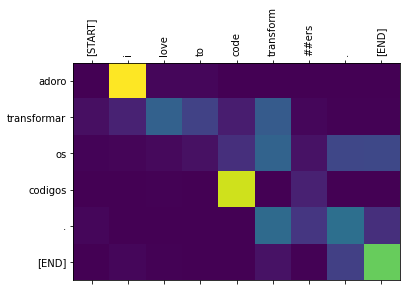

In [49]:
#test sentence 1:
input_sentence = "I love to code transformers."
real_translation = "adoro programar os transformers."

#getting predicting
prediction, tokens, weights = translator(tf.constant(input_sentence))

eval_plotting_function(input_sentence,prediction,tokens,weights,real_translation)

Note that "transformers" is not a noun in the training vocabulary. However, the translator is able to relate it to the verb "transformar", portugese for "transform". As such, the algorithm writes a sentence that can be translated to english as: "I love to transform code". Not quite the original sentence, but one that makes sense. 

Remember that the weights plotted here are the outputs of the softmax function of the weighted query and key vectors. These weigths are then multiplied by the value vector to obtain the target mapping.  

Input Sentence: 
Portugese is a beautiful language.

Predicted Sentence: 
o portugenes e uma lingua linda .

Real Translation: 
O português é uma língua linda.

The attention plot for the 1st head of the last decoder attention block is:


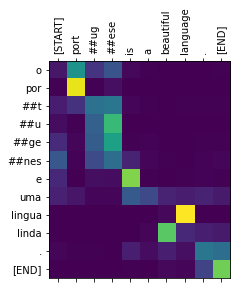

In [47]:
#test sentence 3:
input_sentence = "Portugese is a beautiful language."
real_translation = "O português é uma língua linda."

#getting predicting
prediction, tokens, weights = translator(tf.constant(input_sentence))

eval_plotting_function(input_sentence,prediction,tokens,weights,real_translation)

Input Sentence: 
I would love to work for your company.

Predicted Sentence: 
gostaria de trabalhar para a vossa empresa .

Real Translation: 
Eu adoraria trabalhar para sua empresa.

The attention plot for the 1st head of the last decoder attention block is:


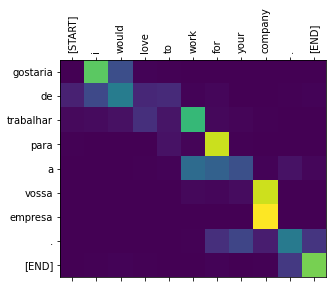

In [48]:
#test sentence 4:
input_sentence = "I would love to work for your company."
real_translation = "Eu adoraria trabalhar para sua empresa."

#getting predicting
prediction, tokens, weights = translator(tf.constant(input_sentence))

eval_plotting_function(input_sentence,prediction,tokens,weights,real_translation)